# Fit of the SIR patch model to CSSE Sand Data

[Index](0-index.ipynb)

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import os,sys
import numpy as np
import pandas as pd
import datetime
import scipy
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('..') / 'code'))
from functions import fsigmoid, fsigmoid_jac, fit_sir

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 831 entries.


## Global variables and other quantities

### Global variables

In [6]:
gamma = 1/10.
ti = '2020-03-01'
tf = '2021-02-16'

tfmt = '%Y-%m-%d'
ti = datetime.datetime.strptime(ti, tfmt)
tf = datetime.datetime.strptime(tf, tfmt)

exts = ['.png', '.svg']

### Load clusters to get population

In [7]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [8]:
population = clusters['population'].to_numpy()
population_inv = np.zeros(population.shape, dtype=np.float_)
idx = population > 0.
population_inv[idx] = 1./population[idx]

### Load CSSEGI data

In [9]:
path = '/clustering/cssegi'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    df_cssegi = store[path]

times = df_cssegi.index
idx = (times >= ti) & (times <= tf)
df_cssegi.drop(index=times[~idx], inplace=True)
times = df_cssegi.index.to_pydatetime().tolist()
df_cssegi

index,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
2020-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12,0,0,0,0,0,0,0,0,1215,239,...,0,0,397,0,181,21712,0,2540,2239,0
2021-02-13,0,0,0,0,0,0,0,0,1221,241,...,0,0,397,0,181,21758,0,2549,2241,0
2021-02-14,0,0,0,0,0,0,0,0,1227,241,...,0,0,397,0,181,21794,0,2553,2244,0
2021-02-15,0,0,0,0,0,0,0,0,1231,241,...,0,0,397,0,181,21817,0,2561,2244,0


In [10]:
omega_real = df_cssegi.to_numpy().astype('float64')
domega_real = np.diff(omega_real, axis=0)
domega_real = np.concatenate([omega_real[0].reshape(1,-1), domega_real], axis=0)

In [11]:
# compute the real epidemic sizes per community through time
T_real = np.einsum('ta,a->ta', omega_real, population_inv)
dT_real = np.einsum('ta,a->ta', domega_real, population_inv)
T_tot_real = np.einsum('ta,a->t', T_real, population) / np.sum(population)
dT_tot_real = np.einsum('ta,a->t', dT_real, population) / np.sum(population)

Show the total epidemic size from real data

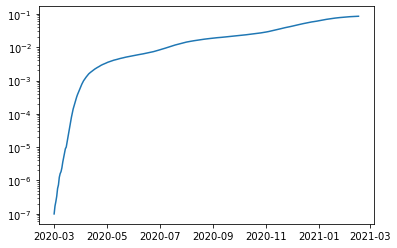

In [12]:
plt.plot(times, T_tot_real)
plt.gca().set_yscale('log')

Show the initial condition

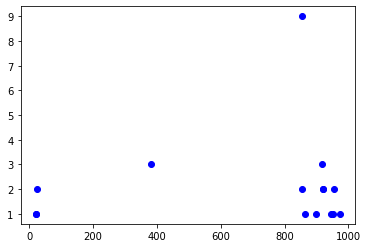

In [13]:
X = clusters.index.to_numpy()
Y = np.einsum('ta,a->ta', T_real, population)[0]
idx = Y > 0
plt.plot(X[idx],Y[idx], 'bo')

## Prepare the infectivity matrices for the fit

In [14]:
# global variable
pathtofit = Path('/fit')
pathtoflux = Path('/fluxes')

In [15]:
from functions import get_infectivity_matrix

In [16]:
# first check that all times have an associated flux matrix
time_fluxes = []
# read the mean flux matrix
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    for rt, dirs, files in store.walk(str(pathtoflux)):
        for f in files:
            t = datetime.datetime.strptime(f, tfmt)
            time_fluxes.append(t)

time_fluxes.sort()

for t in times:
    if not t in time_fluxes:
        raise ValueError("Some dates don't have an associated flux matrix")

In [17]:
# Method 1 - Averaging the flux matrix
N = len(clusters)
L = np.zeros((N,N), dtype=np.float_)
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    for t in times:
        mykey = pathtoflux / t.strftime(tfmt)
        mykey = str(mykey)
        df_flux = store[mykey]
        L += df_flux.to_numpy().astype('float64')
L /= len(times)
L = get_infectivity_matrix(L)
df_loc = pd.DataFrame(data=L, index=clusters.index, columns=clusters.index)

pathtoloc = pathtofit / 'infectivity_matrices'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(pathtoloc / times[0].strftime(tfmt))
    store[mykey] = df_loc

In [18]:
# # Method 2 - Averaging the infectivity matrices

# N = len(clusters)
# L = np.zeros((N,N), dtype=np.float_)
# with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
#     for t in times:
#         mykey = pathtoflux / t.strftime(tfmt)
#         mykey = str(mykey)
#         df_flux = store[mykey]
#         L += get_infectivity_matrix(df_flux.to_numpy().astype('float64'))
# L /= len(times)
# df_loc = pd.DataFrame(data=L, index=clusters.index, columns=clusters.index)

# pathtoloc = pathtofit / 'infectivity_matrices'
# with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
#     mykey = str(pathtoloc / times[0].strftime(tfmt))
#     store[mykey] = df_loc

In [19]:
# export infectivity matrix (unscaled)
expdir = resdir / 'csv'
if not expdir.is_dir():
    expdir.mkdir()

fname = 'infectivity_mean.csv'
df_loc.to_csv(expdir / fname)

## Perform the fit

In [20]:
print("Reading infectivity matrices from: {:s}".format(str(pathtoloc)))
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    df_S, df_I, df_fit = fit_sir(times, T_real, gamma, population, store, pathtoloc, tfmt=tfmt, verbose=True)

path = pathtofit / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(path / 'susceptible')
    store[mykey] = df_S
    
    mykey = str(path / 'infected')
    store[mykey] = df_I
    
    mykey = str(path / 'fit')
    store[mykey] = df_fit

Reading infectivity matrices from: /fit/infectivity_matrices
Integrating day 2020-03-01 00:00:00
b = 0.3432200661383882, y = 1.7076102603876226e-07, ypred = 1.7076102603867512e-07, y-ypred = 8.713851444878615e-20
Integrating day 2020-03-02 00:00:00
Infectivity matrix not updated!
b = 0.20744891049801437, y = 2.3285594459825398e-07, ypred = 2.3285594459819337e-07, y-ypred = 6.061579528788587e-20
Integrating day 2020-03-03 00:00:00
Infectivity matrix not updated!
b = 0.2534537299784254, y = 3.3531256022121396e-07, ypred = 3.3531256022139845e-07, y-ypred = -1.844943638238273e-19
Integrating day 2020-03-04 00:00:00
Infectivity matrix not updated!
b = 0.3745443261786728, y = 5.743779966755594e-07, ypred = 5.743779966755436e-07, y-ypred = 1.5775988642611344e-20
Integrating day 2020-03-05 00:00:00
Infectivity matrix not updated!
b = 0.1771031744152343, y = 7.389295308588252e-07, ypred = 7.389295308582669e-07, y-ypred = 5.583005913589907e-19
Integrating day 2020-03-06 00:00:00
Infectivity matr

## Show agreement with CSSEGI data

In [21]:
figdir = Path('../figures') / '5-SIR_dynamics_fit'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

In [22]:
path = pathtofit / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(path / 'susceptible')
    df_S = store[mykey]
    
    mykey = str(path / 'infected')
    df_I = store[mykey]

In [23]:
idx = df_S.index.to_pydatetime().tolist()
idx.sort()
if (idx != times):
    raise ValueError("Incompatible times!")

S = df_S.to_numpy().astype('float64')
T = (1. - S)
dT = np.diff(T, axis=0)
dT = np.concatenate([T[0].reshape(1,-1), dT], axis=0)

df_T = pd.DataFrame(data=T, index=times, columns=df_S.columns)
df_dT = pd.DataFrame(data=dT, index=times, columns=df_S.columns)

T_tot = np.einsum('ta,a', T, population) / np.sum(population)
dT_tot = np.einsum('ta,a', dT, population) / np.sum(population)

In [24]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1
show_dT=True


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

if show_dT:
    ax.plot(times,dT_tot, '-', ms=ms, color='darkblue')
    ax.plot(times,dT_tot_real, 'o', lw=lw, color='red')
    ax.set_ylabel("$d T$", fontsize="medium")
    fname = 'domega_tot_fit'
else:
    ax.plot(times,omega_tot, 'o', ms=ms, color='darkblue')
    ax.plot(times,omega_tot_real, '-', lw=lw, color='red')
    ax.set_ylabel("$T$", fontsize="medium")
    ax.set_yscale('log')
    fname = 'omega_tot_fit'

ax.set_xlim(times[0],None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/5-SIR_dynamics_fit/domega_tot_fit.png
Written file: ../figures/5-SIR_dynamics_fit/domega_tot_fit.svg


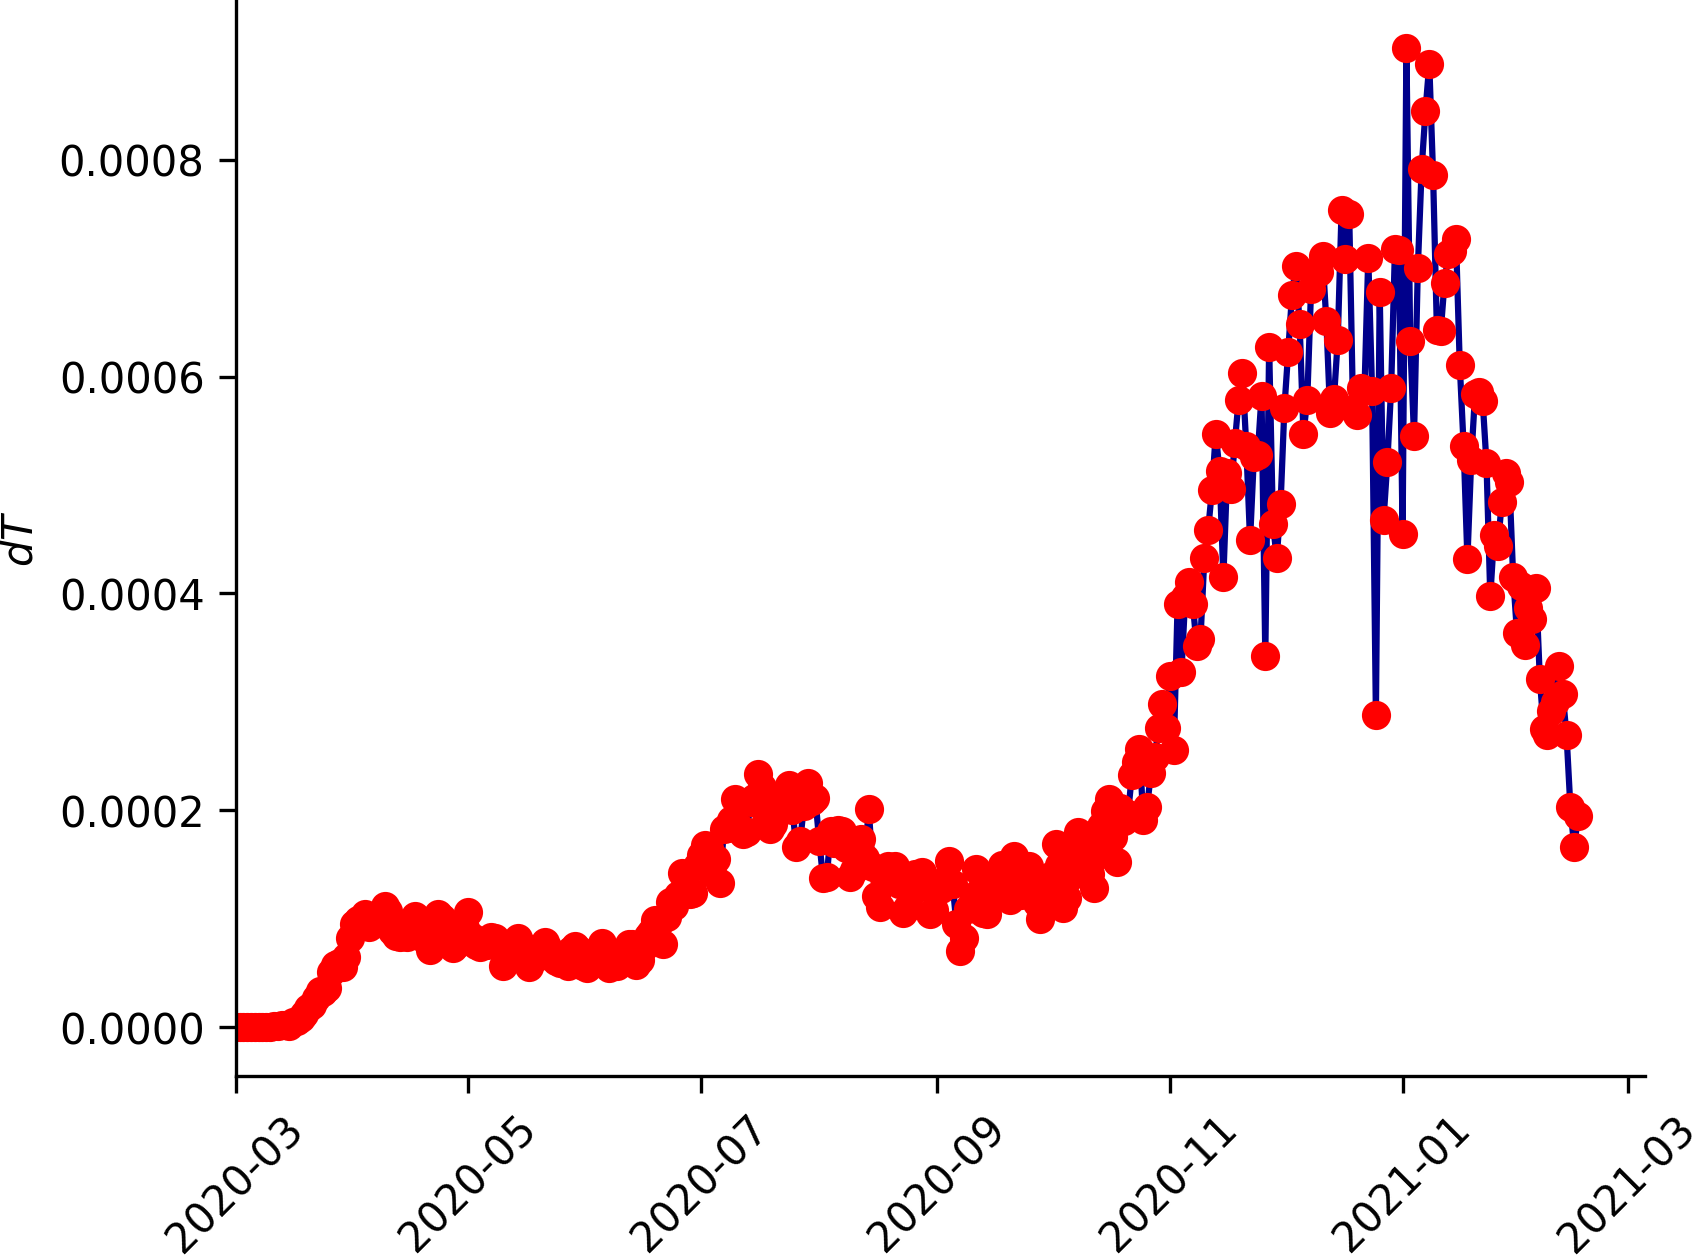

In [25]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Fit the scale

In [26]:
path = pathtofit / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(path / 'fit')
    df_fit = store[mykey]

In [27]:
# fit to sigmoid
df_idx = df_fit.dropna().index
X = (df_idx - df_idx[0]).days.to_numpy().astype('float64')
Y = df_fit.loc[df_idx, "scale"].to_numpy().astype('float64')

popt, pcov = curve_fit(fsigmoid, X, Y, p0=[0.,0.,0.,0.], jac=fsigmoid_jac, method='lm')

Ysigmoid = fsigmoid(X, *popt).astype('float64')

# build step function
a, b, c, d = popt
A = a+c
B = c
x0 = int(np.round(b)) # must be an integer to represent a day

Ystep = np.ones(len(X), dtype=np.float_)*A
idx = X>=x0
Ystep[idx] = B

In [28]:
df_fit['scale_sigmoid'] = None
df_fit.loc[df_idx, 'scale_sigmoid'] = Ysigmoid

df_fit['scale_step'] = None
df_fit.loc[df_idx, 'scale_step'] = Ystep

path = pathtofit / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    mykey = str(path / 'fit')
    store[mykey] = df_fit

expdir = resdir / 'csv'
if not expdir.is_dir():
    expdir.mkdir()

fname = 'fit_scale.csv'
df_fit.to_csv(expdir / fname)

In [29]:
path = pathtofit / 'result'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(path / 'fit')
    df_fit = store[mykey]
    
df_fit

,scale,frac_infected_tot,scale_sigmoid,scale_step
2020-03-01,0.34322,0.0,0.251068,0.253942
2020-03-02,0.207449,0.0,0.250534,0.253942
2020-03-03,0.253454,0.0,0.249903,0.253942
2020-03-04,0.374544,0.0,0.249158,0.253942
2020-03-05,0.177103,0.000001,0.24828,0.253942
...,...,...,...,...
2021-02-12,0.040918,0.083887,0.055336,0.055336
2021-02-13,0.03206,0.084156,0.055336,0.055336
2021-02-14,0.027507,0.08436,0.055336,0.055336
2021-02-15,0.033736,0.084526,0.055336,0.055336


In [30]:
# parameters
figsize = (8,4.5)
dpi = 300
ms=2
lw=1

X = df_fit.dropna().index
Y, Ysigmoid, Ystep = df_fit.dropna().loc[:,['scale', 'scale_sigmoid','scale_step']].to_numpy().astype('float64').T

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

ax.plot(X,Y, 'o', ms=ms, color='k')
ax.plot(X,Ysigmoid, '-', lw=lw, color='darkblue')
ax.plot(X,Ystep, '-', lw=lw, color='darkgreen')

ax.set_xlim(X[0],None)
# ax.set_ylim(1.0e-7, 1.0e-1)
ax.set_xlabel("date", fontsize="medium")
ax.set_ylabel("$p \\beta$", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'scales'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/5-SIR_dynamics_fit/scales.png
Written file: ../figures/5-SIR_dynamics_fit/scales.svg


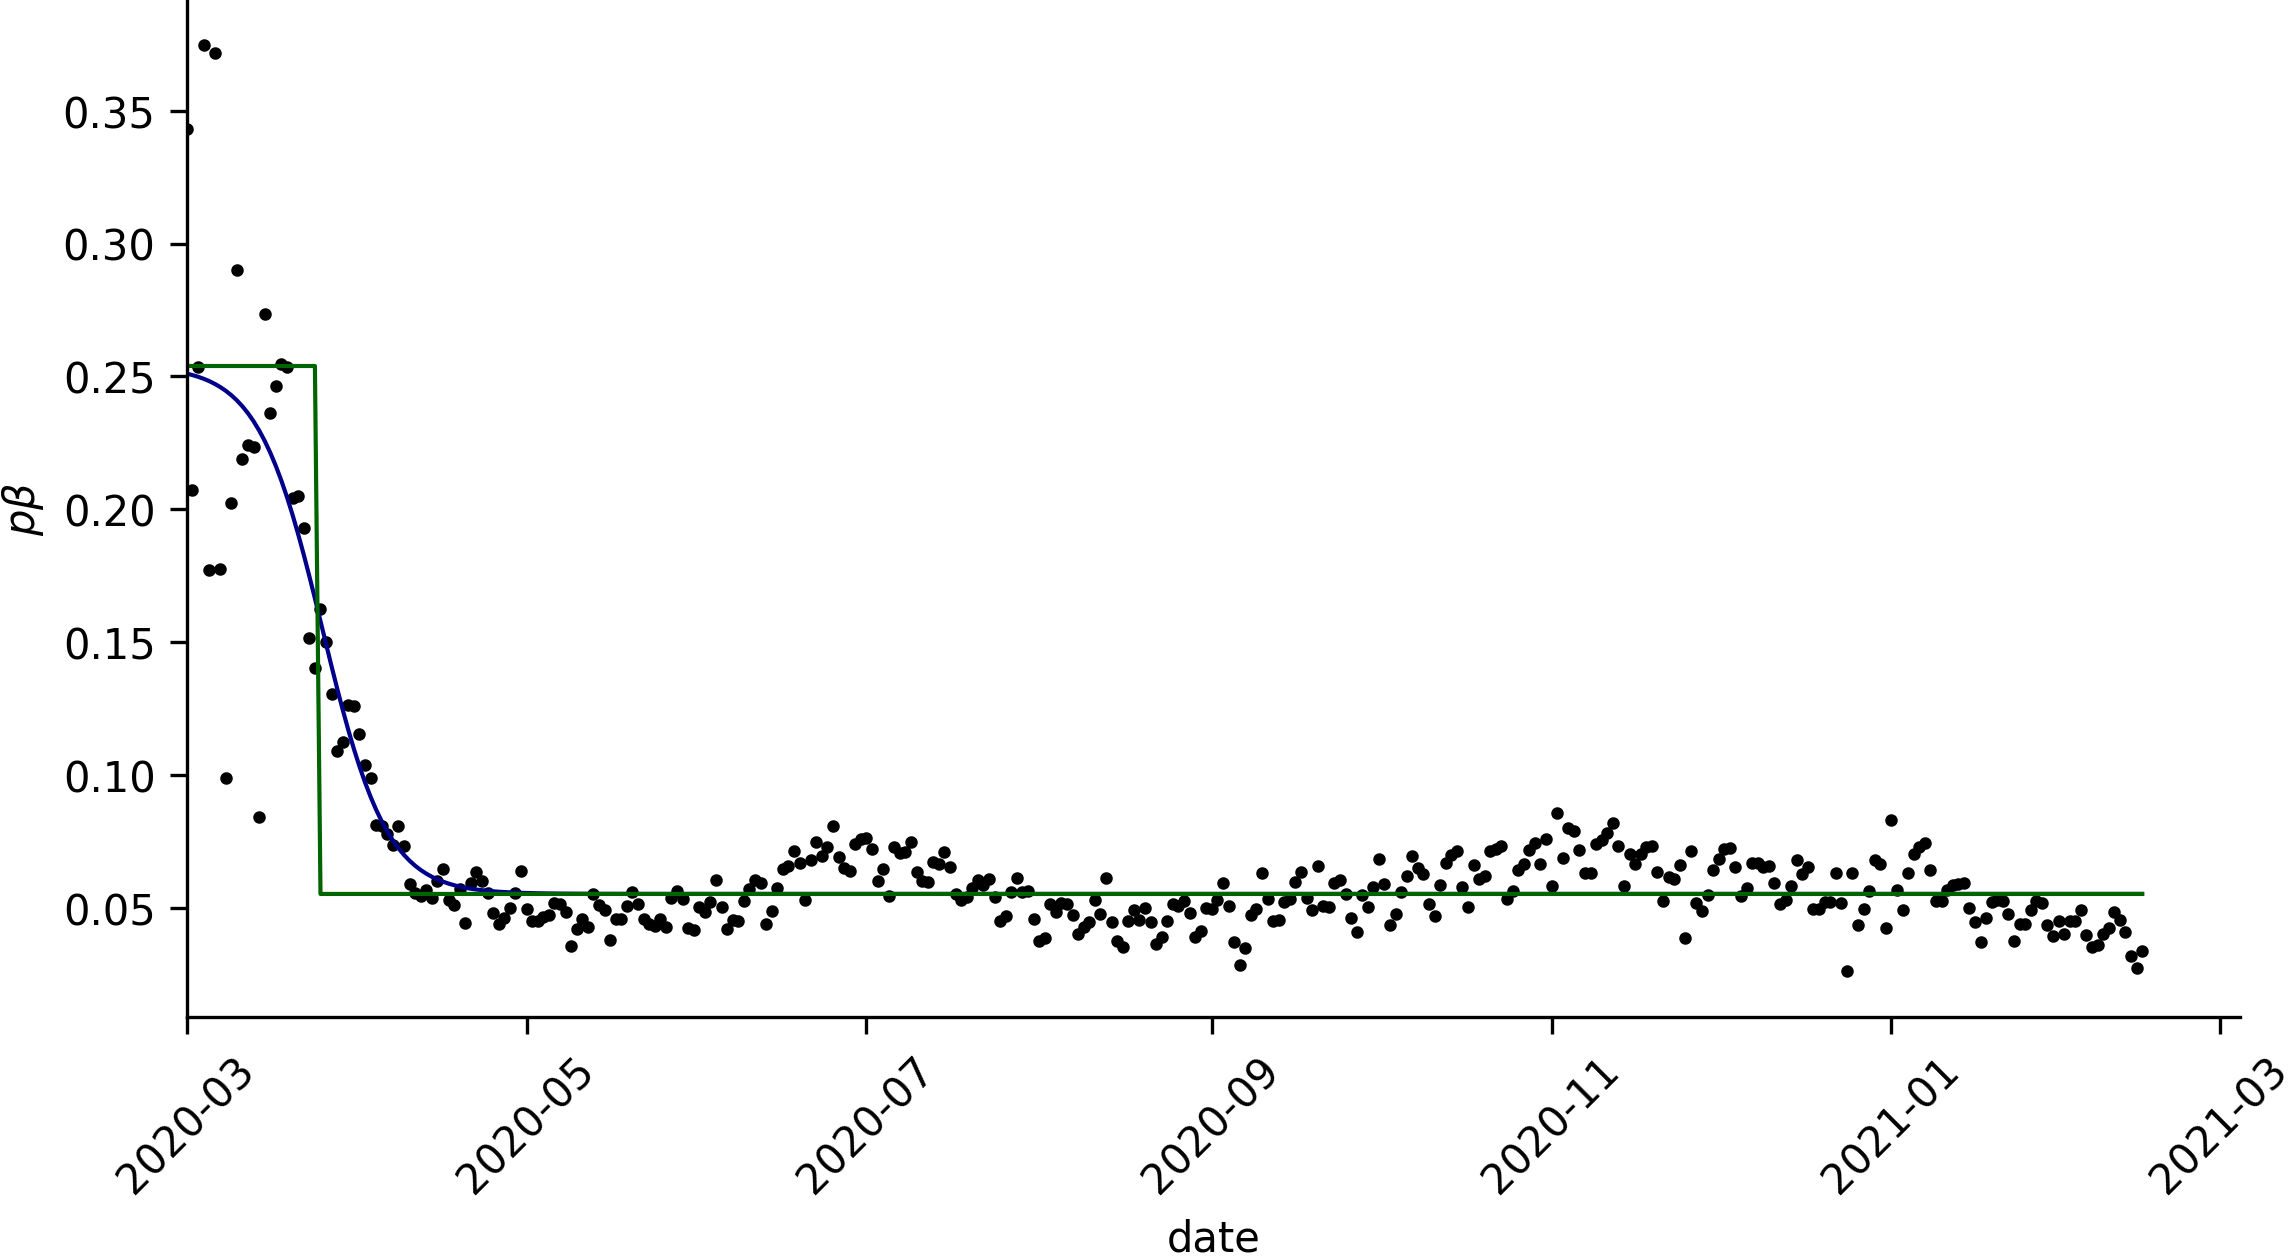

In [31]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

Retrieving the shift-time

In [32]:
b_scales = df_fit['scale_step'].fillna(value=np.nan).to_numpy()
ic = np.nanargmax(np.abs(np.diff(b_scales))) + 1
tc = df_fit.index[ic]
print(f"lockdown at t = {tc}")

lockdown at t = 2020-03-25 00:00:00


In [33]:
df_fit.iloc[ic-1:ic+2]

,scale,frac_infected_tot,scale_sigmoid,scale_step
2020-03-24,0.140192,0.000172,0.166496,0.253942
2020-03-25,0.162633,0.000208,0.157958,0.055336
2020-03-26,0.150148,0.000259,0.14937,0.055336


## Show local agreement between reported cases and the model

In [34]:
from dateutil.relativedelta import relativedelta

Show $T_a$

In [36]:
# parameters
vmin = 1.0e0
vmax = 1.0e6
cmap = cm.rainbow
figsize=(4,3)
dpi=300
idump=10

## color mapping with date value
indices = np.arange(len(times))
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
colors = cmap(norm(indices))

## make figure
fig = plt.figure(facecolor='w', figsize=figsize, dpi=dpi)
ax = fig.gca()

for i in np.arange(len(times))[::idump]:
    t = times[i]
    X = T_real[i]*population
    Y = T[i]*population
    
    ax.plot(X, Y, 'o', color=colors[i], lw=0, mew=0, ms=2, alpha=0.3)    

ax.plot([vmin, vmax], [vmin, vmax], 'k-', lw=0.5)
# plot formatting
ax.set_xlabel("$T_a^{real}$", fontsize='medium')
ax.set_ylabel("$T_a$", fontsize='medium')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
ax.tick_params(length=4)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
        
    
fig.tight_layout(rect=[0.,0.,0.95,1.])
cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax, extendfrac='auto')
nmonth = (times[-1].year-times[0].year)*12 + (times[-1].month-times[0].month)
tick_values = np.array([times[0] + relativedelta(months=i) for i in range(nmonth+1)])
tick_values = tick_values[::2]
ticks = [times.index(t) for t in tick_values]
# labels = [times[(t-1)*window].strftime('%Y-%m-%d') for t in np.array(ticks, dtype=np.int_)]
labels = [t.strftime('%Y-%m-%d') for t in tick_values]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

fname = 'T_model_vs_real'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')
# plt.show()

Written file: ../figures/5-SIR_dynamics_fit/T_model_vs_real.png
Written file: ../figures/5-SIR_dynamics_fit/T_model_vs_real.svg


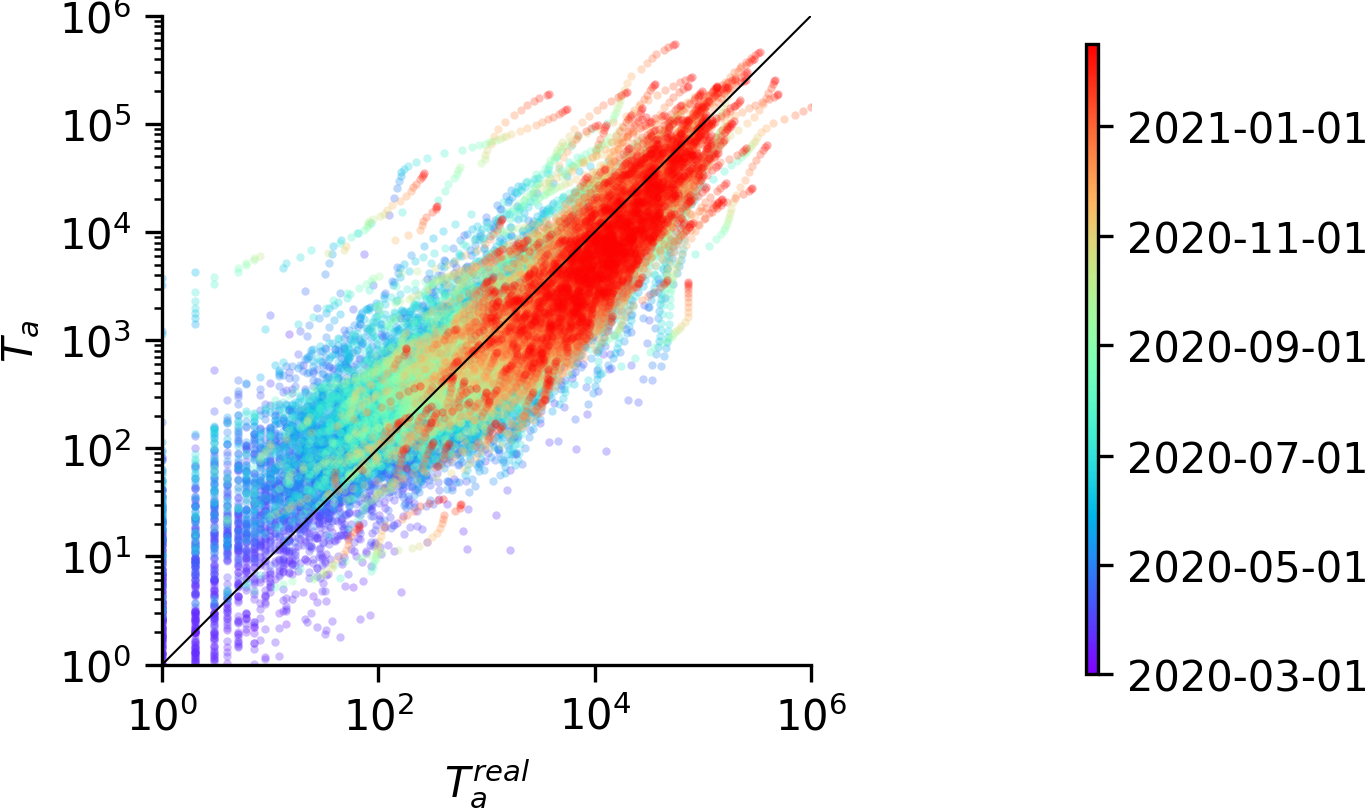

In [37]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

Show $dT_a$

In [38]:
# parameters
vmin = 1.0e0
vmax = 1.0e4
cmap = cm.rainbow
figsize=(4,3)
dpi=300
idump=10

## color mapping with date value
indices = np.arange(len(times))
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
colors = cmap(norm(indices))

## make figure
fig = plt.figure(facecolor='w', figsize=figsize, dpi=dpi)
ax = fig.gca()

for i in np.arange(len(times))[::idump]:
    t = times[i]
    X = dT_real[i]*population
    Y = dT[i]*population
    
    ax.plot(X, Y, 'o', color=colors[i], lw=0, mew=0, ms=2, alpha=0.3)    

ax.plot([vmin, vmax], [vmin, vmax], 'k-', lw=0.5)
# plot formatting
ax.set_xlabel("$dT_a^{real}$", fontsize='medium')
ax.set_ylabel("$dT_a$", fontsize='medium')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
ax.tick_params(length=4)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
    
fig.tight_layout(rect=[0.,0.,0.95,1.])
cax = fig.add_axes(rect=[0.99,0.2,0.01,0.7])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=cax, extendfrac='auto')
nmonth = (times[-1].year-times[0].year)*12 + (times[-1].month-times[0].month)
tick_values = np.array([times[0] + relativedelta(months=i) for i in range(nmonth+1)])
tick_values = tick_values[::2]
ticks = [times.index(t) for t in tick_values]

labels = [t.strftime('%Y-%m-%d') for t in tick_values]
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)


fname = 'dT_model_vs_real'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')
# plt.show()

Written file: ../figures/5-SIR_dynamics_fit/dT_model_vs_real.png
Written file: ../figures/5-SIR_dynamics_fit/dT_model_vs_real.svg


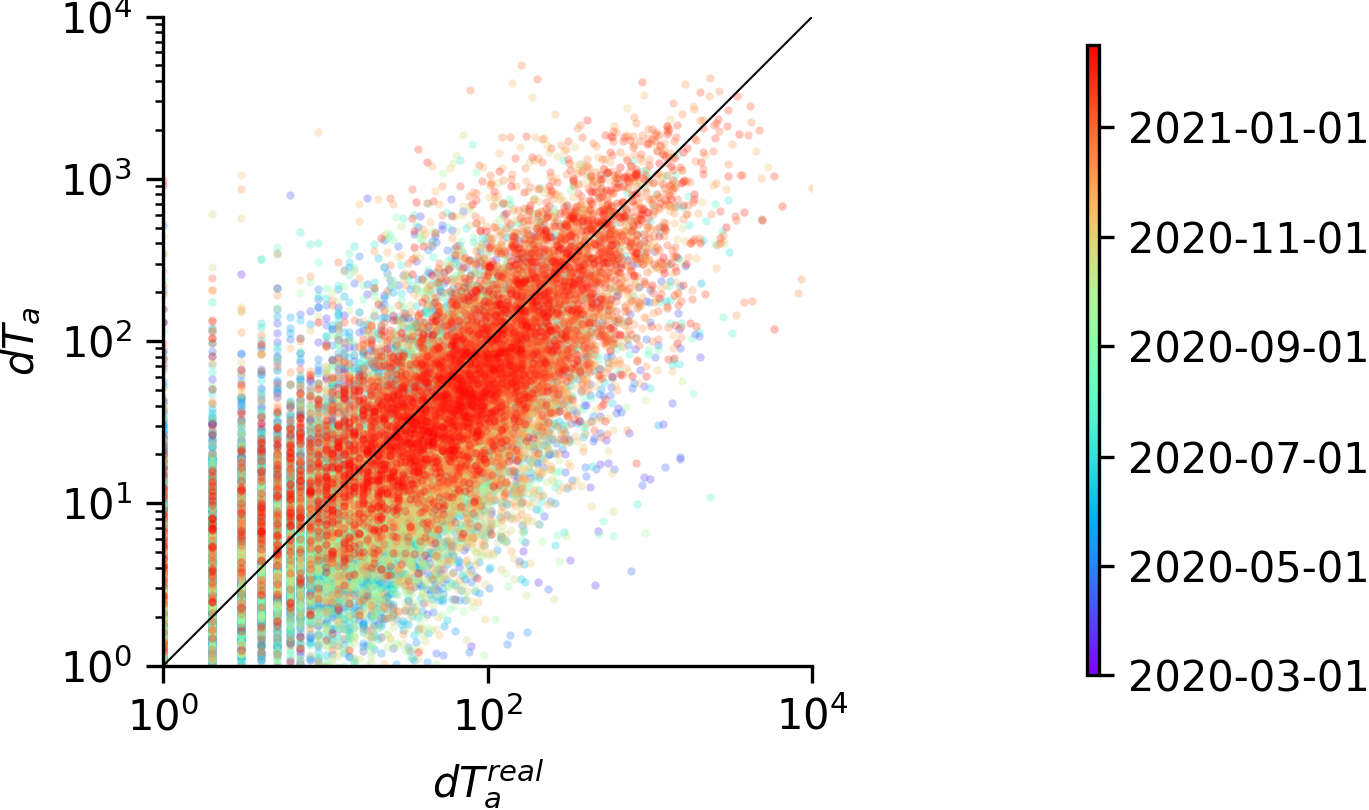

In [39]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Show time-dependent profile

In [40]:
from functions import plot_omega_profile

In [41]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4

mydir = figdir / 'profiles'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)

fpath = mydir / 'profile_T.mp4'
T_list = np.array([np.einsum('ta,a->ta', T_real[:,:],population), np.einsum('ta,a->ta', T[:,:], population)])
ylabel="$T_a$"
# T_list = np.array([np.einsum('ta,a->ta', domega_real, population), np.einsum('ta,a->ta', dT, population)]) / np.sum(population)
plot_omega_profile(T_list, times, labels=['real', 'model'], colors=['red', 'darkblue'], \
                   fileout=fpath, tpdir=mydir / 'snapshots_T', dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=['o', '-'], deletetp=False, exts=['.png','.svg'], ymin=1.)

fpath = mydir / 'profile_dT.mp4'
T_list = np.array([np.einsum('ta,a->ta', dT_real[:,:],population), np.einsum('ta,a->ta', dT[:,:], population)])
ylabel="$dT_a$"
plot_omega_profile(T_list, times, labels=['real', 'model'], colors=['red', 'darkblue'], \
                   fileout=fpath, tpdir=mydir / 'snapshots_dT', dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=['o', '-'], deletetp=False, exts=['.png','.svg'], ymin=1.)

ymin = 1.00e+00 ymax = 1.00e+07
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-03-01.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-03-11.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-03-21.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-03-31.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-04-10.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-04-20.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-04-30.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-05-10.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-05-20.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-05-30.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-06-09.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_T/2020-06-19.png.
Written 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (795, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/5-SIR_dynamics_fit/profiles/profile_T.mp4.
ymin = 1.00e+00 ymax = 1.00e+05
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-03-01.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-03-11.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-03-21.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-03-31.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-04-10.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-04-20.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-04-30.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-05-10.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-05-20.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-05-30.png.
Written file ../figures/5-SIR_dynamics_fit/profiles/snapshots_dT/2020-06-09.png.
Written fi

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (796, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/5-SIR_dynamics_fit/profiles/profile_dT.mp4.


In [42]:
fpath = figdir / 'profiles' / 'profile_T.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

In [43]:
fpath = figdir / 'profiles' / 'profile_dT.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

## Show time-dependent map

In [44]:
from functions import plot_omega_map

In [45]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4
idump=1

mydir = figdir / 'maps'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)


fpath = mydir / 'map_T.mp4'
plot_omega_map(np.einsum('ta,a->ta', T, population), times, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
fileout=fpath, tpdir=mydir / 'snapshots_T', dpi=dpi, fps=fps, figsize=figsize, idump=idump, \
               clabel="$T$", vmin=1., deletetp=False, exts=['.png','.svg'])
    
fpath = mydir / 'map_dT.mp4'
plot_omega_map(np.einsum('ta,a->ta', dT, population), times, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
fileout=fpath, tpdir=mydir / 'snapshots_dT', dpi=dpi, fps=fps, figsize=figsize, idump=idump, \
               clabel="$dT$", vmin=1., deletetp=False, exts=['.png','.svg'])

vmin = 1.00e+00 vmax = 1.00e+06
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-01.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-02.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-03.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-04.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-05.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-06.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-07.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-08.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-09.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-10.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-11.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_T/2020-03-12.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshot

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/5-SIR_dynamics_fit/maps/map_T.mp4.
vmin = 1.00e+00 vmax = 1.00e+04
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-01.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-02.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-03.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-04.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-05.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-06.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-07.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-08.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-09.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-10.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2020-03-11.png.
Written file ../figures/5-SIR_dynamics_fit/maps/snapshots_dT/2

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/5-SIR_dynamics_fit/maps/map_dT.mp4.


In [46]:
fpath = figdir / 'maps' / 'map_T.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

In [47]:
fpath = figdir / 'maps' / 'map_dT.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))